# Bazowa implementacja

## [Zadanie](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org6058800)
Na potrzeby pracy domowej należy zaimplementować sieć neuronową typu MLP, w której można ustawić:
- liczbę warstw,
- liczbę neuronów w każdej z warstw,
- wagi poszczególnych połączeń, w tym biasów.

Sieć ma używać sigmoidalnej funkcji aktywacji. Na wyjściu dopuszczana jest funkcja liniowa.

Implementacja sieci musi być przygotowana w taki sposób, żeby łatwo zmieniać:
- architekturę, to znaczy liczbę wejść, wyjść, neuronów w warstwach ukrytych,
- funkcję aktywacji.

Tak przygotowaną implementację należy następnie wykorzystać do rozwiązania zadania regresji na dostarczonych danych.  
Parametry sieci należy dobrać ręcznie, tak aby uzyskać możliwie dobrze wyniki na zbiorach danych (zbudować po jednej sieci dla każdego zbioru):
- square-simple
- steps-large

Rozważyć architektury sieci:
- jedna warstwa ukryta, 5 neuronów,
- jedna warstwa ukryta, 10 neuronów,
- dwie warstwy ukryte, po 5 neuronów każda.

## Wstęp teoretyczny 
Zadaniem **perceptronu** jest klasyfikacja podanego na wejście wektora x do jednej z dwóch klas $C1$ lub $C2$. Jeśli sygnał wyjściowy neuronu przyjmuje wartość 1 to wektor $x$ jest zaklasyfikowany do klasy $C1$, jeśli przyjmuje wartość 0 to do klasy $C2$. Perceptron dzieli $N$-wymiarową przestrzeń wektorów wejściowych na dwie półprzestrzenie rozdzielone $N−1$ wymiarową hiperpłaszczyzną. Hiperpłaszczyzna ta zwana jest granicą decyzyjną. Jeśli przestrzeń obiektów jest dwuwymiarowa to rozdzielająca je granica jest linią prostą.  
**Multilayer Perceptron**, **MLP** – typ sztucznych sieci neuronowych składający się zwykle z jednej warstwy wejściowej, kilku warstw ukrytych oraz jednej warstwy wyjściowej gdzie warstwy ukryte składają się najczęściej z neuronów **McCullocha-Pittsa**. Warstwa wyjściowa natomiast może składać się z neuronów liniowych (w przypadku regresji) lub neuronów nieliniowych (w przypadku klasyfikacji).  
W przypadku sieci wielowarstwowych najczęściej stosowanym algorytmem uczenia jest algorytm wstecznej propagacji błędów. Jego nazwa pochodzi stąd, iż po obliczeniu odpowiedzi sieci na zadany wzorzec, obliczana jest wartość gradientu funkcji błędu dla neuronów ostatniej warstwy. Następnie modyfikuje się ich wagi. Błąd jest propagowany do warstwy wcześniejszej (przedostatniej). Wartości funkcji gradientu dla neuronów z tej warstwy obliczane są w oparciu o gradienty dla neuronów z warstwy następnej (czyli ostatniej). Modyfikowane są wagi kolejnej warstwy. Postępowanie trwa aż do warstwy wejściowej.  


Referencje do materiałów wykorzystanych na potrzeby wykonania zadania:
1. https://pl.wikipedia.org/wiki/Perceptron_wielowarstwowy
2. https://en.wikipedia.org/wiki/Multilayer_perceptron
3. http://books.icse.us.edu.pl/runestone/static/ai/SztuczneSieciNeuronowe/PodstawoweModeleSieciNeuronowych.html
4. http://books.icse.us.edu.pl/runestone/static/ai/SztuczneSieciNeuronowe/SztuczneSieciNeuronowe.html#fig-modelmp

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics

# Square-simple dataset

In [2]:
trainset = pd.read_csv('../data/mio1/regression/square-simple-training.csv', index_col=0)
testset = pd.read_csv('../data/mio1/regression/square-simple-test.csv', index_col=0)
trainset

,x,y
1,-0.171543,-127.351580
2,0.025201,-129.942844
3,-1.368991,38.672367
4,1.907390,197.432191
5,0.011129,-129.988852
...,...,...
96,0.529373,-104.778766
97,1.374914,40.134900
98,-1.101985,-20.706642
99,1.175777,-5.579327


In [3]:
trainset['split'] = 'train'
testset['split'] = 'test'
dataFrame = pd.concat([trainset, testset])

Text(0.5, 1.0, 'Train split')

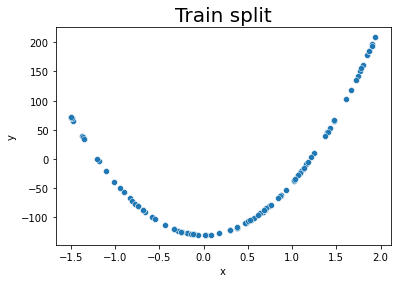

In [4]:
sns.scatterplot(x='x', y='y', data=trainset)
plt.title('Train split', fontsize=20)

Text(0.5, 1.0, 'Test split')

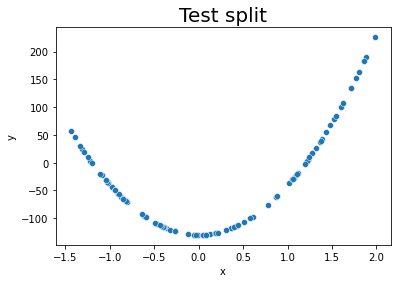

In [5]:
sns.scatterplot(x='x', y='y', data=testset)
plt.title('Test split', fontsize=20)

<AxesSubplot:xlabel='x', ylabel='y'>

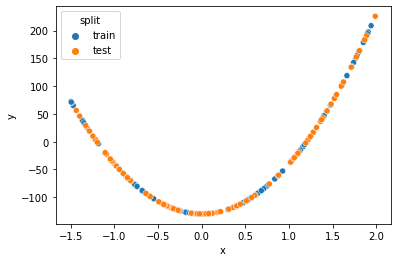

In [6]:
sns.scatterplot(x='x', y='y', hue='split', data=dataFrame)

In [7]:
def sigmoid_activation_function(x):
    return (1 / (1 + np.exp(-x)))


class MLP:
    def __init__(self, in_size, neurons_cardinalities, weights, out_size = 1,
                 activation_function = sigmoid_activation_function):
        """
        Takes:
        in_size - input number
        out_size - output number
        neurons_cardinalities - list of numbers of neurons in subsequent hidden layers
        weights - list of matrices, ought to match numbers of neurons in each hidden layer
        activation_function - neural networks activation function
        
        Presence of at least one hidden layer is an accompanying assumption
        """
        
        # number of subsequent hidden layers
        self.layers = len(neurons_cardinalities)
        
        self.weights = weights
        neurons_cardinalities.insert(len(neurons_cardinalities), out_size)
        neurons_cardinalities.insert(0, in_size)
        
        
    def forward(self, X):
        current_layer = X
        for i in range(0, self.layers):
            current_layer = sigmoid_activation_function(
                    np.c_[np.ones(current_layer.shape[0]), current_layer] @ self.weights[i])

        # a linear function is acceptable on the function output
        current_layer = np.c_[np.ones(current_layer.shape[0]), current_layer] @ self.weights[self.layers]
        return current_layer

### Jedna warstwa ukryta, 5 neuronów

Text(0.5, 1.0, 'Architektura: 1 warstwa ukryta, 5 neuronów')

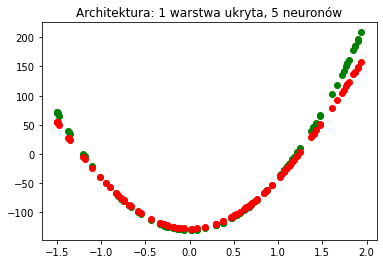

In [8]:
mlp1 = MLP(in_size = 1,
           neurons_cardinalities = [5],
           weights = [np.array([[2, 1, 0, -1, -2], # 2 neurony -> 5 neuronów (macierz 2x5)
                               [-1, -1, -1, -1, -1]]),
                     np.array([[650], [-900], [-200], [0], [200], [900]])]) # 6 neuronów -> 1 neuron (macierz 6x1)
           
           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp1.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 1 warstwa ukryta, 5 neuronów")

In [9]:
metrics.mean_absolute_error(trainset['y'], prediction)

8.366181727622482

### Jedna warstwa ukryta, 10 neuronów

Text(0.5, 1.0, 'Architektura: 1 warstwa ukryta, 10 neuronów')

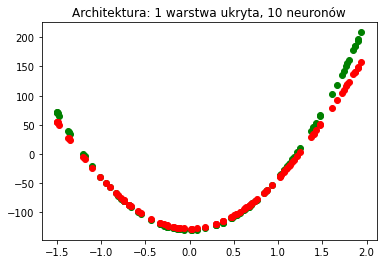

In [10]:
mlp2 = MLP(in_size = 1,
           neurons_cardinalities = [10],
           weights = [np.array([[2, 1, 0, -1, -2, 0,0,0,0,0], # 2 neurony -> 10 neuronów (macierz 2x10)
                               [-1, -1, -1, -1, -1, 0,0,0,0,0]]),
                     np.array([[650], [-900], [-200], [0], [200], [900], # 11 neuronów -> 1 neuron (macierz 11x1)
                               [0], [0], [0], [0], [0]])])
           
           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp2.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 1 warstwa ukryta, 10 neuronów")

In [11]:
metrics.mean_absolute_error(trainset['y'], prediction)

8.366181727622484

### Dwie warstwy ukryte, każda po 5 neuronów

Text(0.5, 1.0, 'Architektura: 2 warstwy ukryte po 5 neuronów')

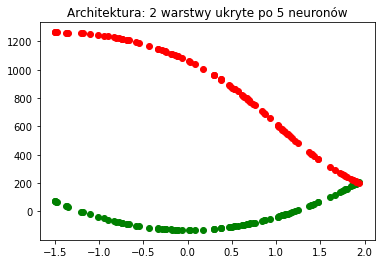

In [12]:
"""
Losowe wagi - nie podejmuję się przeszukiwania siatki ze względu na mnogość parametrów
"""

mlp3 = MLP(in_size = 1,
           neurons_cardinalities = [5, 5],
           weights = [np.array([[-2, -1, 0, 1, 2], [2, 1, 0, -1, 2]]), # 2 neurony -> 5 neuronów (macierz 2x5)
                      np.array([[-2, -1, 0, 1, 2], [1, 1, 1, 1, 1], [2, 1, 0, 1, 2], # 6 neuronów -> 5 neuronów (macierz 6x5)
                                [-1, -1, -1, -1, -1], [-2, -1, 0, 1, 2], [2, 1, 0, 1, 2]]),
                      np.array([[1000], [-850], [-1000], [0], [1500], [-900]])]) # 6 neuronów -> 1 neuron (macierz 6x1)
           
           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp3.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 2 warstwy ukryte po 5 neuronów")

In [13]:
metrics.mean_absolute_error(trainset['y'], prediction)

871.1049855257988

# Steps-large dataset

In [14]:
trainset = pd.read_csv('../data/mio1/regression/steps-large-training.csv', index_col=0)
testset = pd.read_csv('../data/mio1/regression/steps-large-test.csv', index_col=0)
trainset

,x,y
1,-1.481354,-80
2,1.033264,80
3,-0.076403,0
4,-1.419785,-80
5,-0.108398,0
...,...,...
9996,1.281784,80
9997,0.460459,0
9998,0.810917,80
9999,0.644318,80


In [15]:
trainset['split'] = 'train'
testset['split'] = 'test'
dataFrame = pd.concat([trainset, testset])

Text(0.5, 1.0, 'Train split')

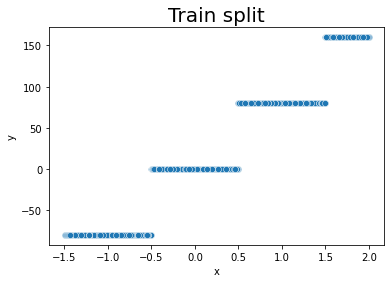

In [16]:
sns.scatterplot(x='x', y='y', data=trainset)
plt.title('Train split', fontsize=20)

Text(0.5, 1.0, 'Test split')

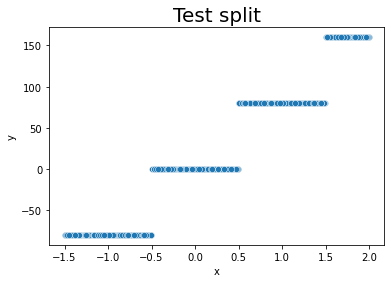

In [17]:
sns.scatterplot(x='x', y='y', data=testset)
plt.title('Test split', fontsize=20)

<AxesSubplot:xlabel='x', ylabel='y'>

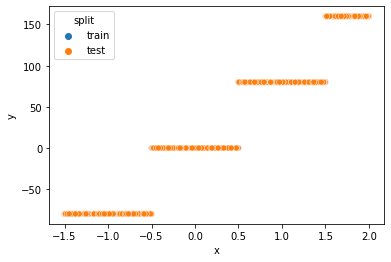

In [18]:
sns.scatterplot(x='x', y='y', hue='split', data=dataFrame)

### Jedna warstwa ukryta, 5 neuronów

Text(0.5, 1.0, 'Architektura: 1 warstwa ukryta, 5 neuronów')

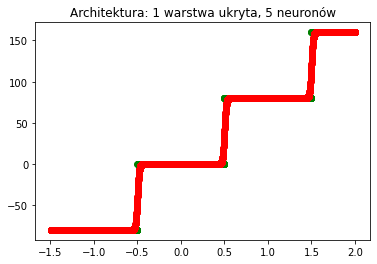

In [19]:
mlp4 = MLP(in_size=1,
           neurons_cardinalities=[5],
           weights = [np.array([[-50, -150, 50, -50, 50], # 2 neurony -> 5 neuronów (macierz 2x5)
                               [100, 100, 100, 100, 0]]),
                     np.array([[-80], [80], [80], [80], [0], [0]])]) # 6 neuronów -> 1 neuron (macierz 6x1)

           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp4.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 1 warstwa ukryta, 5 neuronów")

In [20]:
metrics.mean_absolute_error(trainset['y'], prediction)

0.950452563159524

### Jedna warstwa ukryta, 10 neuronów

Text(0.5, 1.0, 'Architektura: 1 warstwa ukryta, 10 neuronów')

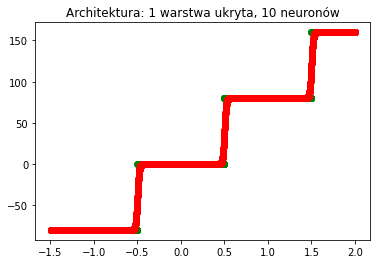

In [21]:
mlp5 = MLP(in_size = 1,
           neurons_cardinalities = [10],
           weights = [np.array([[-50, -150, 50, -50, 50, 0,0,0,0,0], # 2 neurony -> 10 neuronów (macierz 2x10)
                               [100, 100, 100, 100, 0, 0,0,0,0,0]]),
                     np.array([[-80], [80], [80], [80], [0], [0], # 11 neuronów -> 1 neuron (macierz 11x1)
                               [0], [0], [0], [0], [0]])])
           
           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp5.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 1 warstwa ukryta, 10 neuronów")

In [22]:
metrics.mean_absolute_error(trainset['y'], prediction)

0.950452563159524

### Dwie warstwy ukryte, każda po 5 neuronów

Text(0.5, 1.0, 'Architektura: 2 warstwy ukryte po 5 neuronów')

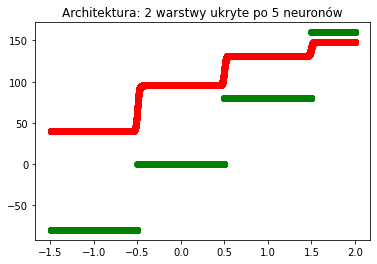

In [23]:
"""
Losowe wagi - nie podejmuję się przeszukiwania siatki ze względu na mnogość parametrów
"""

mlp6 = MLP(in_size = 1,
           neurons_cardinalities = [5, 5],
           weights = [np.array([[-50, -150, 50, -50, 50], # 2 neurony -> 5 neuronów (macierz 2x5)
                               [100, 100, 100, 100, 0]]), 
                      np.array([np.zeros(5), np.zeros(5), np.ones(5), # 6 neuronów -> 5 neuronów (macierz 6x5)
                                np.ones(5), np.ones(5), np.zeros(5)]),
                      np.array([[-80], [80], [80], [80], [0], [0]])]) # 6 neuronów -> 1 neuron (macierz 6x1)
           
           
x = trainset['x'].values
x = np.expand_dims(x, 1)
prediction = mlp6.forward(x)

plt.scatter(trainset['x'], trainset['y'], color='green', label = "actual")
plt.scatter(trainset['x'], prediction, color='red', label = "predicted")
plt.title("Architektura: 2 warstwy ukryte po 5 neuronów")

In [24]:
metrics.mean_absolute_error(trainset['y'], prediction)

77.6326743903112